In [45]:
%matplotlib inline
import pandas as pd
from pandas import set_option
#Limit dataframe exibition to 8 rows
set_option("display.max_rows", 5)
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc

Vamos fazer previsões inicialmente usando dados até 2011, pois 2012 é o ponto que percebemos que a diferença começa a aumentar bastante, então esse aqui seria um cenário mais otimista

In [46]:
df = pd.read_csv('./processed/regres.csv', encoding='latin1')

In [47]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [48]:
df.columns

Index([u'ano', u'dif'], dtype='object')

Para a previsão vamos usar o Prophet, que é uma biblioteca para modelos preditivos do time "Time Series" bastante simples de usar

In [49]:
from fbprophet import Prophet

In [50]:
m = Prophet()

In [51]:
df['ds'] = ''

Vamos Criar data para cada ano, como sendo o último dia de cada ano

In [52]:
for i in range(len(df)):
    df['ds'][i] = str(df['ano'][i])+'-12-31'

/home/guilherme/xgboost/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
df.drop('ano', axis=1, inplace=True)

In [54]:
df = df.rename(columns={'dif':'y'})

In [55]:
m.fit(df)

Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [56]:
future = m.make_future_dataframe(periods=20, freq='A')

In [57]:
forecast = m.predict(future)

In [58]:
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
27,2027-12-31,2.454817,1.503989e+10,-5.692902e+08,-5.692902e+08,1.503989e+10,1.503989e+10,9.291567e+09,1.983456e+10,-5.692902e+08,-5.692902e+08,-5.692902e+08,-5.692902e+08,1.447060e+10
28,2028-12-31,2.545930,1.594630e+10,-5.692576e+08,-5.692576e+08,1.594630e+10,1.594631e+10,1.034517e+10,2.017674e+10,-5.692576e+08,-5.692576e+08,-5.692576e+08,-5.692576e+08,1.537705e+10
29,2029-12-31,2.636794,1.685024e+10,-5.696740e+08,-5.696740e+08,1.685024e+10,1.685024e+10,1.112907e+10,2.149562e+10,-5.696740e+08,-5.696740e+08,-5.696740e+08,-5.696740e+08,1.628057e+10
30,2030-12-31,2.727657,1.775418e+10,-5.696848e+08,-5.696848e+08,1.775417e+10,1.775418e+10,1.237846e+10,2.201074e+10,-5.696848e+08,-5.696848e+08,-5.696848e+08,-5.696848e+08,1.718449e+10
31,2031-12-31,2.818521,1.865812e+10,-5.692902e+08,-5.692902e+08,1.865811e+10,1.865812e+10,1.257664e+10,2.307452e+10,-5.692902e+08,-5.692902e+08,-5.692902e+08,-5.692902e+08,1.808883e+10


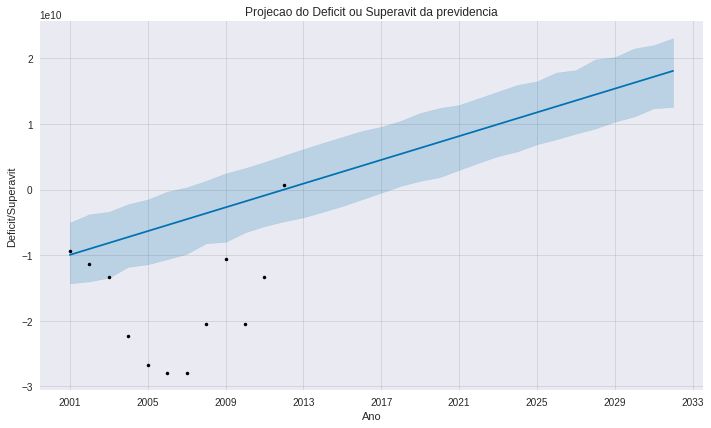

In [59]:
m.plot(forecast)
plt.ylabel('Deficit/Superavit')
plt.xlabel('Ano')
plt.title('Projecao do Deficit ou Superavit da previdencia')

### Agora faremos a mesma previsão, mas com todos os dados que temos

In [60]:
df = pd.read_csv('./processed/prev.csv', encoding='latin1')

In [61]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [62]:
ignorado = pd.read_csv('./processed/arrec_ignorado.csv', encoding='latin1', sep=',')
ignorado.drop(['Unnamed: 0','cd_ibge'], axis=1, inplace=True)

In [63]:
agrupado = pd.DataFrame(df.groupby(by=['estado','ano'])['vl_emissao','vl_arrecadado'].sum()).reset_index()

In [64]:
por_ano = agrupado.groupby(by=['ano'])['vl_emissao','vl_arrecadado'].sum().reset_index()

In [65]:
ignorado_por_ano = ignorado.drop('estado', axis=1)

In [66]:
por_ano_total = pd.merge(por_ano, ignorado_por_ano, how='inner', on='ano')

In [67]:
por_ano_total['vl_arrec_tot'] = por_ano_total['vl_arrecadado'] + por_ano_total['vl_arrec']

In [68]:
por_ano_total.drop(['vl_arrecadado', 'vl_arrec'], axis=1, inplace=True)

In [69]:
por_ano_total['dif'] = por_ano_total['vl_arrec_tot'] - por_ano_total['vl_emissao']

In [70]:
por_ano_total.drop(['vl_arrec_tot', 'vl_emissao'], axis=1, inplace=True)

In [71]:
por_ano_total['ds'] = ''

In [72]:
for i in range(len(por_ano_total)):
    por_ano_total['ds'][i] = str(por_ano_total['ano'][i])+'-12-31'

/home/guilherme/xgboost/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
por_ano_total.drop('ano', axis=1, inplace=True)
por_ano_total = por_ano_total.rename(columns={'dif':'y'})

In [74]:
from fbprophet import Prophet

In [75]:
n = Prophet()

In [76]:
n.fit(por_ano_total)

Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [77]:
future = n.make_future_dataframe(periods=2, freq='A')

In [78]:
forecast = n.predict(future)

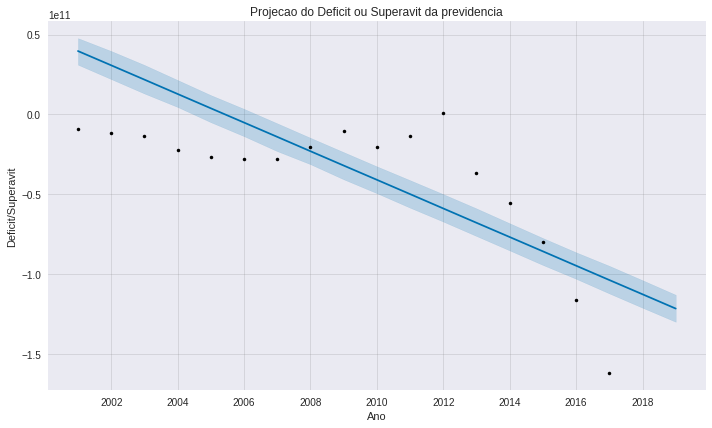

In [79]:
n.plot(forecast)
plt.ylabel('Deficit/Superavit')
plt.xlabel('Ano')
plt.title('Projecao do Deficit ou Superavit da previdencia')